In [1]:
import os
import sys
import uuid
import shutil
from collections import Counter, OrderedDict

import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.ops import box_iou

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import cv2

import PIL

from tqdm.auto import tqdm

In [2]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cuda')

In [3]:
diatom_dataset_root_dir = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

In [4]:
classes = {
  1: "Gomphonema olivaceum",
  2: "Navicula cryptotenella",
  3: "Fragilaria recapitellata",
  4: "Encyonema silesiacum",
  5: "Navicula reichardtiana",
  6: "Planothidium lanceolatum",
  7: "Gomphonema tergestinum",
  8: "Navicula cryptotenelloides",
  9: "Rhoicosphenia abbreviata",
  10: "Meridion circulare",
  11: "Surirella brebissonii var. kuetzingii",
  12: "Encyonema ventricosum",
  13: "Achnanthidium biasolettianum",
  14: "Cymbella excisa",
  15: "Diatoma moniliformis",
  16: "Cymbella cantonatii",
  17: "Diatoma mesodon",
  18: "Humidophila contenta",
  19: "Cocconeis pseudolineata",
  20: "Navicula upsaliensis",
  21: "Cymbella excisa var. subcapitata",
  22: "Halamphora veneta",
  23: "Gomphonema calcifugum",
  24: "Nitzschia linearis",
  25: "Pinnularia brebissonii",
  26: "Humidophila perpusilla",
  27: "Navicula trivialis",
  28: "Gomphonema pumilum var. rigidum",
  29: "Halamphora paraveneta",
  30: "Nitzschia hantzschiana",
  31: "Pantocsekiella ocellata",
  32: "Planothidium frequentissimum",
  33: "Adlafia minuscula",
  34: "Navicula cryptocephala",
  35: "Amphora pediculus",
  36: "Navicula tripunctata",
  37: "Navicula gregaria",
  38: "Nitzschia archibaldii",
  39: "Navicula moskalii",
  40: "Epithemia argus",
  41: "Gomphonema micropus",
  42: "Gomphonema minutum",
  43: "Navicula capitatoradiata",
  44: "Gomphonema drutelingense",
  45: "Denticula kuetzingii",
  46: "Gomphonema supertergestinum",
  47: "Achnanthidium minutissimum",
  48: "Frustulia vulgaris",
  49: "Gomphonema pumilum",
  50: "Hantzschiana abundans",
  51: "Caloneis lancettula",
  52: "Navicula novaesiberica",
  53: "Sellaphora radiosa",
  54: "Navicula lanceolata",
  55: "Gomphonema exilissimum",
  56: "Diploneis fontanella",
  57: "Luticola nivalis",
  58: "Epithemia goeppertiana",
  59: "Nitzschia recta",
  60: "Stauroneis blazenciciae",
  61: "Cymbopleura amphicephala",
  62: "Cymbella excisa var. procera",
  63: "Nitzschia palea",
  64: "Didymosphenia geminata",
  65: "Sellaphora saugerresii",
  66: "Amphora inariensis",
  67: "Neidiomorpha binodiformis",
  68: "Surella minuta"
}

class_to_idx = {v: k for k, v in classes.items()}

In [5]:
banned_xml_files = [
  "388.xml",
  "1147.xml",
  "366.xml",
  "1418.xml",
  "488.xml",
  "1256.xml",
  "475.xml",
  "1067.xml",
  "1310.xml",
  "453.xml",
  "284.xml",
  "233.xml",
  "437.xml",
]

In [6]:
def parse_xml(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  objs = []

  for obj in root.findall("objects/object"):
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "objects": objs
  }

parse_xml(os.path.join(diatom_xmls_dir, "25.xml"))

{'filename': '25.png',
 'objects': [{'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [7]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, classes, class_to_idx, banned_xml_files=[], transform=None, train=True):
    self.root_dir = root_dir
    self.classes = classes
    self.class_to_idx = class_to_idx
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xml_files = [
      xml_file for xml_file in self.xml_files if xml_file.endswith(".xml") and xml_file not in banned_xml_files
    ]

    split_idx = int(len(self.xml_files) * 0.8)

    if train:
      self.xml_files = self.xml_files[:split_idx]
    else:
      self.xml_files = self.xml_files[split_idx:]

  def __len__(self):
    return len(self.xml_files)

  def __getitem__(self, index):
    xml = parse_xml(os.path.join(self.xml_dir, self.xml_files[index]))

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [8]:
train_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=True
)

val_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=False
)

In [9]:
train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=4,
  shuffle=True,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  persistent_workers=True,
  collate_fn=lambda batch: tuple(zip(*batch))
)

val_dataloader = DataLoader(
  dataset=val_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  persistent_workers=True,
  collate_fn=lambda batch: tuple(zip(*batch))
)

In [10]:
def to_device(images, targets):
  return [image.to(device) for image in images], [{k: v.to(device) for k, v in target.items()} for target in targets]

In [11]:
def get_fasterrcnn_model(num_classes):
  weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
  model = fasterrcnn_resnet50_fpn(weights=weights)

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

  return model

def get_retinanet_model(num_classes):
  weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
  model = retinanet_resnet50_fpn(weights=weights)

  in_features = model.backbone.out_channels
  num_anchors = model.head.classification_head.num_anchors

  model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
  )

  return model

In [12]:
def match_predictions_to_ground_truth(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.2):
  y_true, y_pred = [], []

  ious = box_iou(pred_boxes, gt_boxes)
  matched_pred = set()
  matched_gt = set()

  iou_pairs = torch.nonzero(ious > iou_threshold, as_tuple=False)
  iou_scores = ious[iou_pairs[:, 0], iou_pairs[:, 1]]
  sorted_indices = torch.argsort(iou_scores, descending=True)

  for idx in sorted_indices:
    pred_idx, gt_idx = iou_pairs[idx]
    pi, gi = pred_idx.item(), gt_idx.item()
      
    if pi in matched_pred or gi in matched_gt:
        continue
        
    y_true.append(gt_labels[gi].item())
    y_pred.append(pred_labels[pi].item())
      
    matched_pred.add(pi)
    matched_gt.add(gi)

  for pi in range(len(pred_boxes)):
    if pi not in matched_pred:
      y_true.append(-1)
      y_pred.append(pred_labels[pi].item())

  for gi in range(len(gt_boxes)):
    if gi not in matched_gt:
      y_true.append(gt_labels[gi].item())
      y_pred.append(-1)

  return y_true, y_pred

In [13]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
  cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

  fig, ax = plt.subplots(figsize=(15, 15))
    
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(
    cmap="Blues",
    xticks_rotation=90,
    ax=ax,
    colorbar=True
  )

  ax.tick_params(labelsize=6)
  ax.set_title(title, fontsize=14)
    
  plt.tight_layout()
  plt.show()

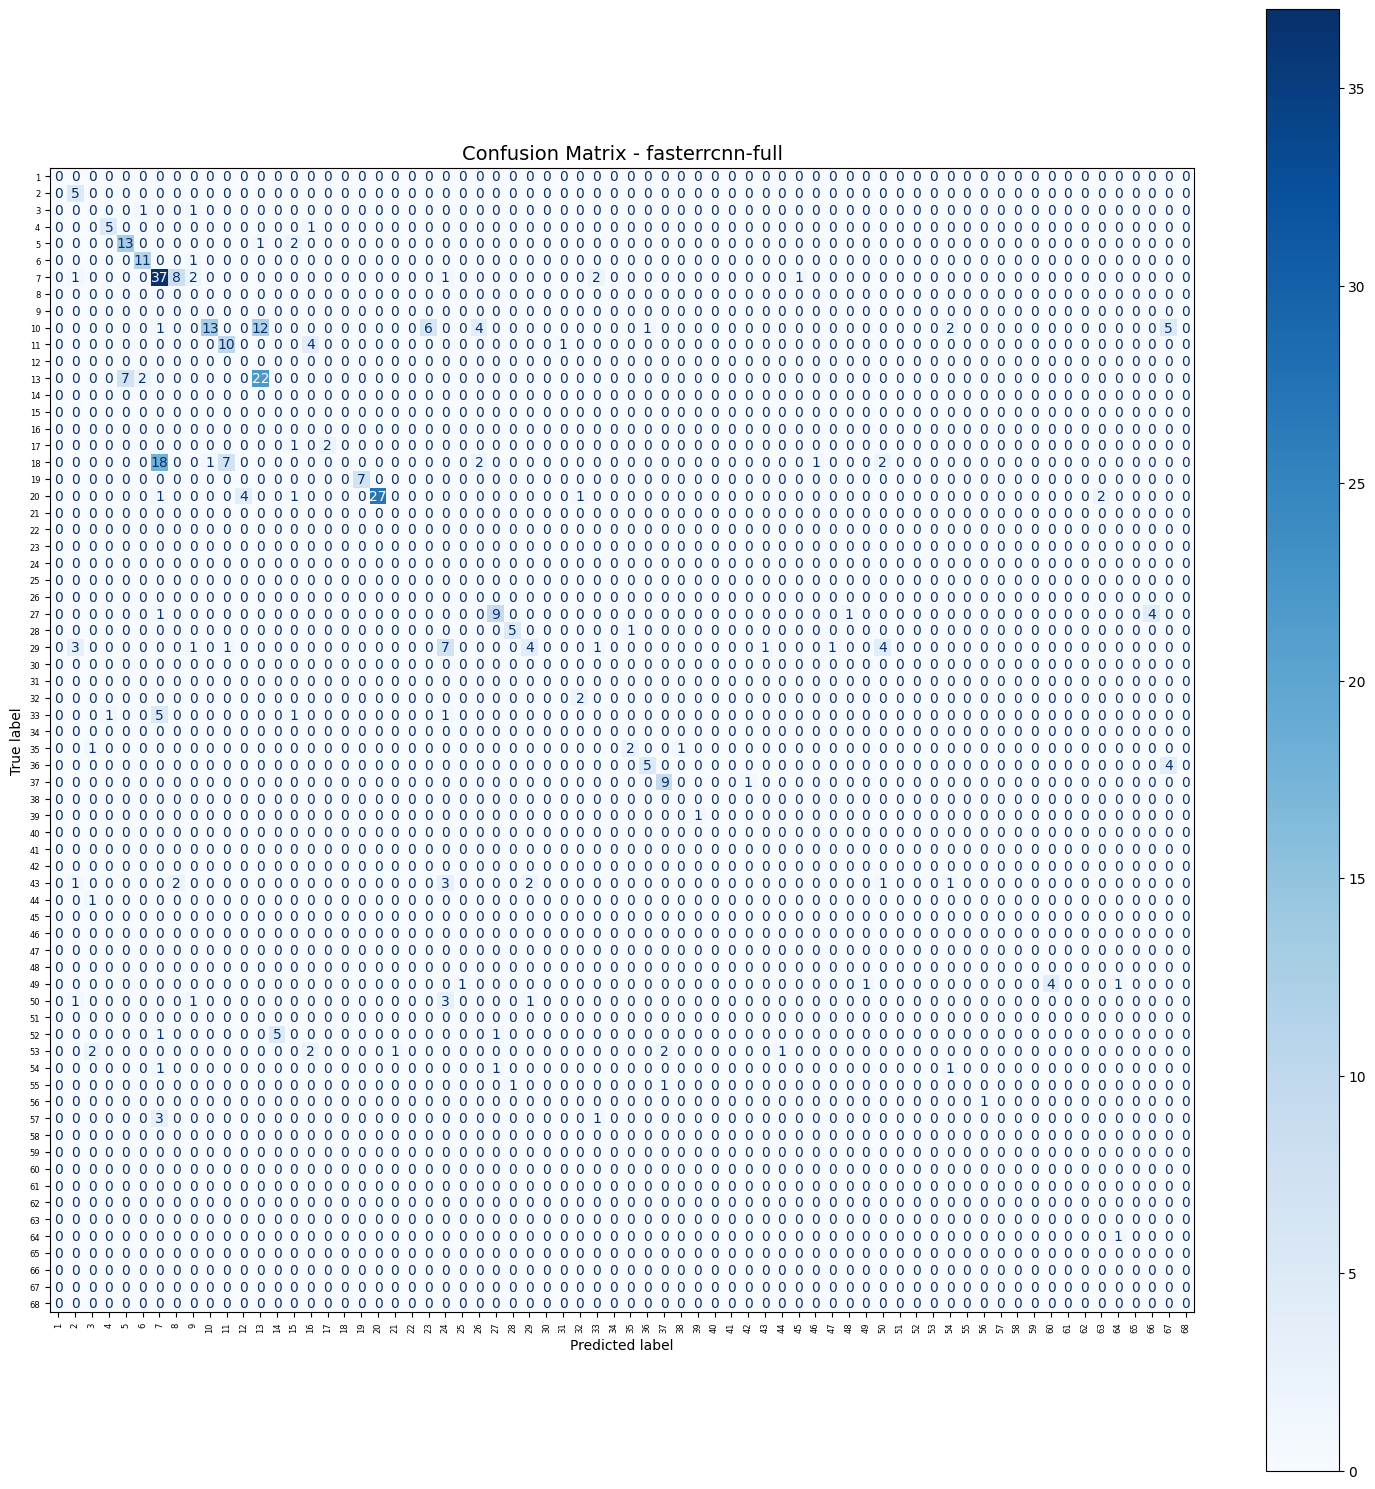

In [14]:
group = "fasterrcnn-full"

checkpoint = torch.load(os.path.join(group, "epoch50.pt"), map_location=device)

model = get_fasterrcnn_model(len(classes) + 1).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

predictions = []
targets = []

model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
  for images, targets in tqdm(val_dataloader, desc="Testing"):
    images, targets = to_device(images, targets)

    outputs = model(images)

    for output, target in zip(outputs, targets):
      y_true, y_pred = match_predictions_to_ground_truth(
          output["boxes"], output["labels"], target["boxes"], target["labels"]
      )
      y_true_all.extend(y_true)
      y_pred_all.extend(y_pred)

plot_confusion_matrix(y_true_all, y_pred_all, classes, title=f"Confusion Matrix - {group}")

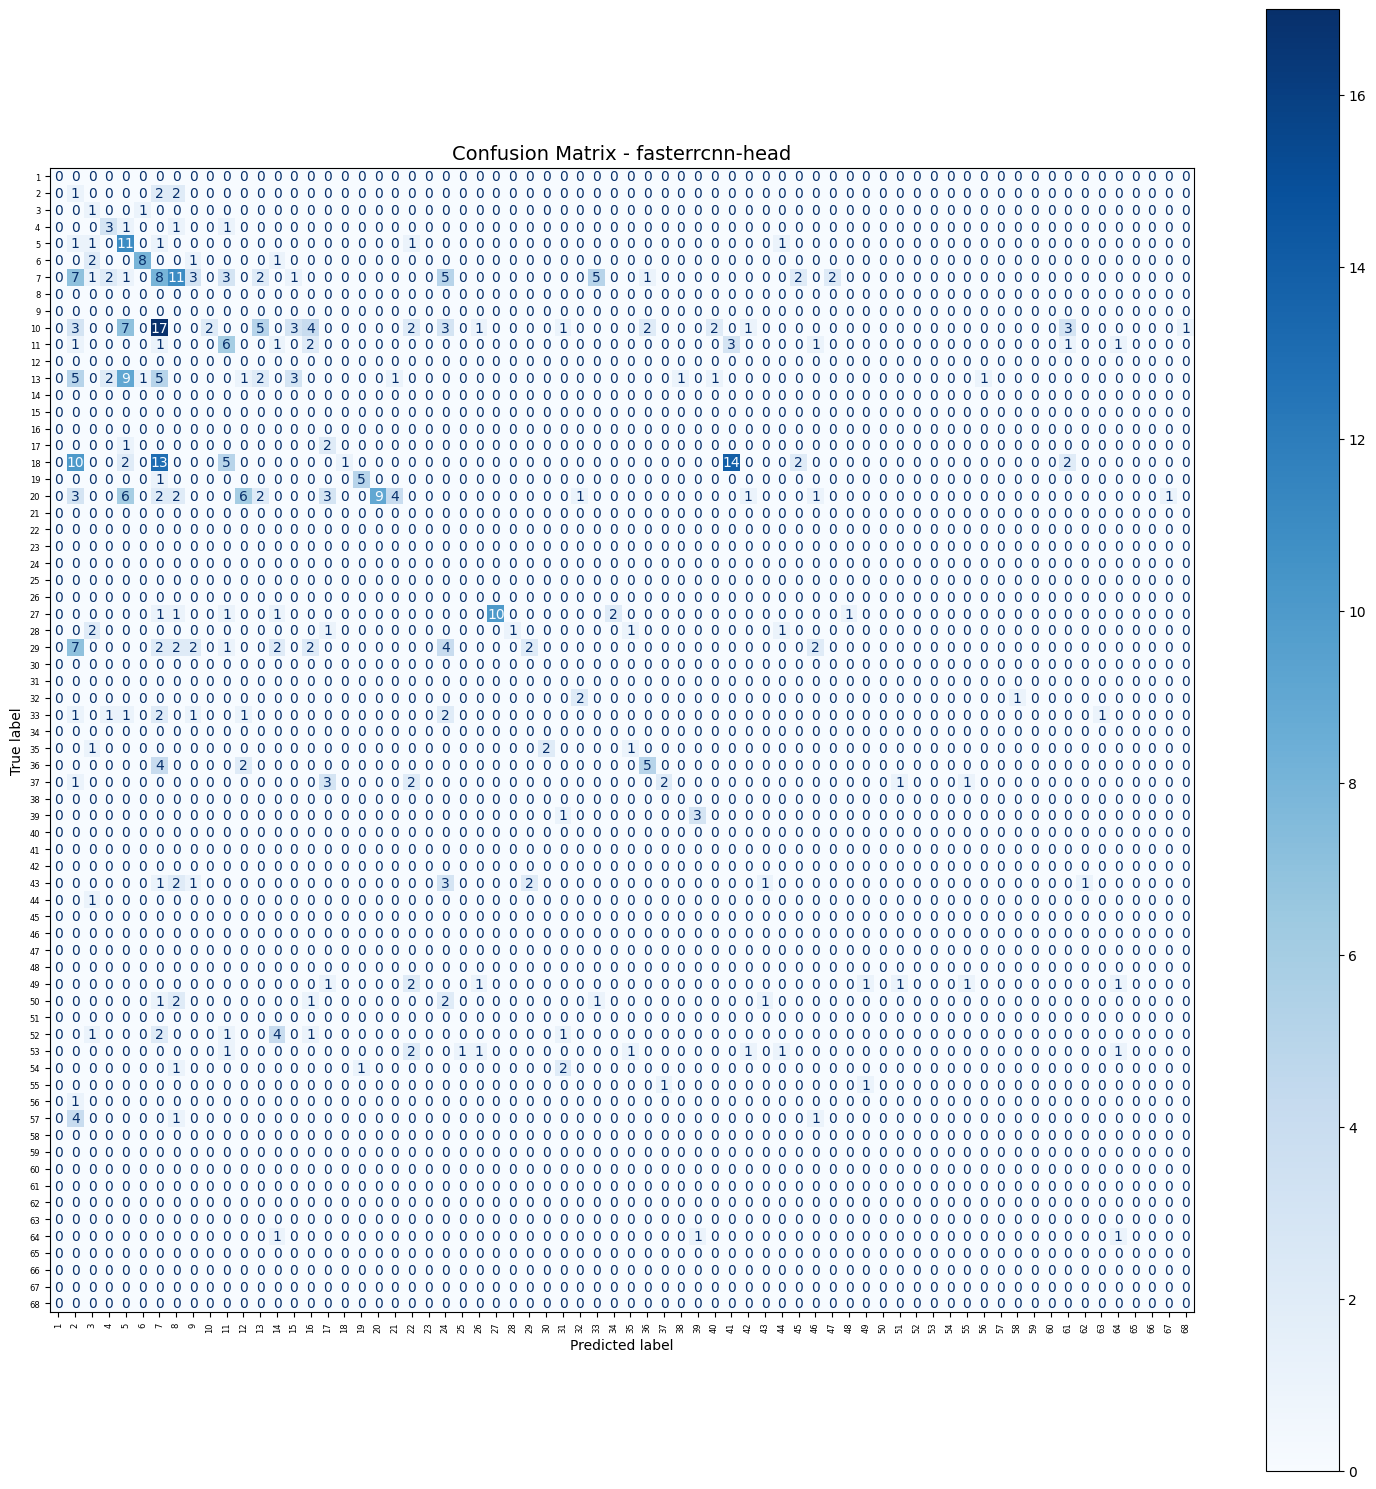

In [15]:
group = "fasterrcnn-head"

checkpoint = torch.load(os.path.join(group, "epoch50.pt"), map_location=device)

model = get_fasterrcnn_model(len(classes) + 1).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

predictions = []
targets = []

model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
  for images, targets in tqdm(val_dataloader, desc="Testing"):
    images, targets = to_device(images, targets)

    outputs = model(images)

    for output, target in zip(outputs, targets):
      y_true, y_pred = match_predictions_to_ground_truth(
          output["boxes"], output["labels"], target["boxes"], target["labels"]
      )
      y_true_all.extend(y_true)
      y_pred_all.extend(y_pred)

plot_confusion_matrix(y_true_all, y_pred_all, classes, title=f"Confusion Matrix - {group}")

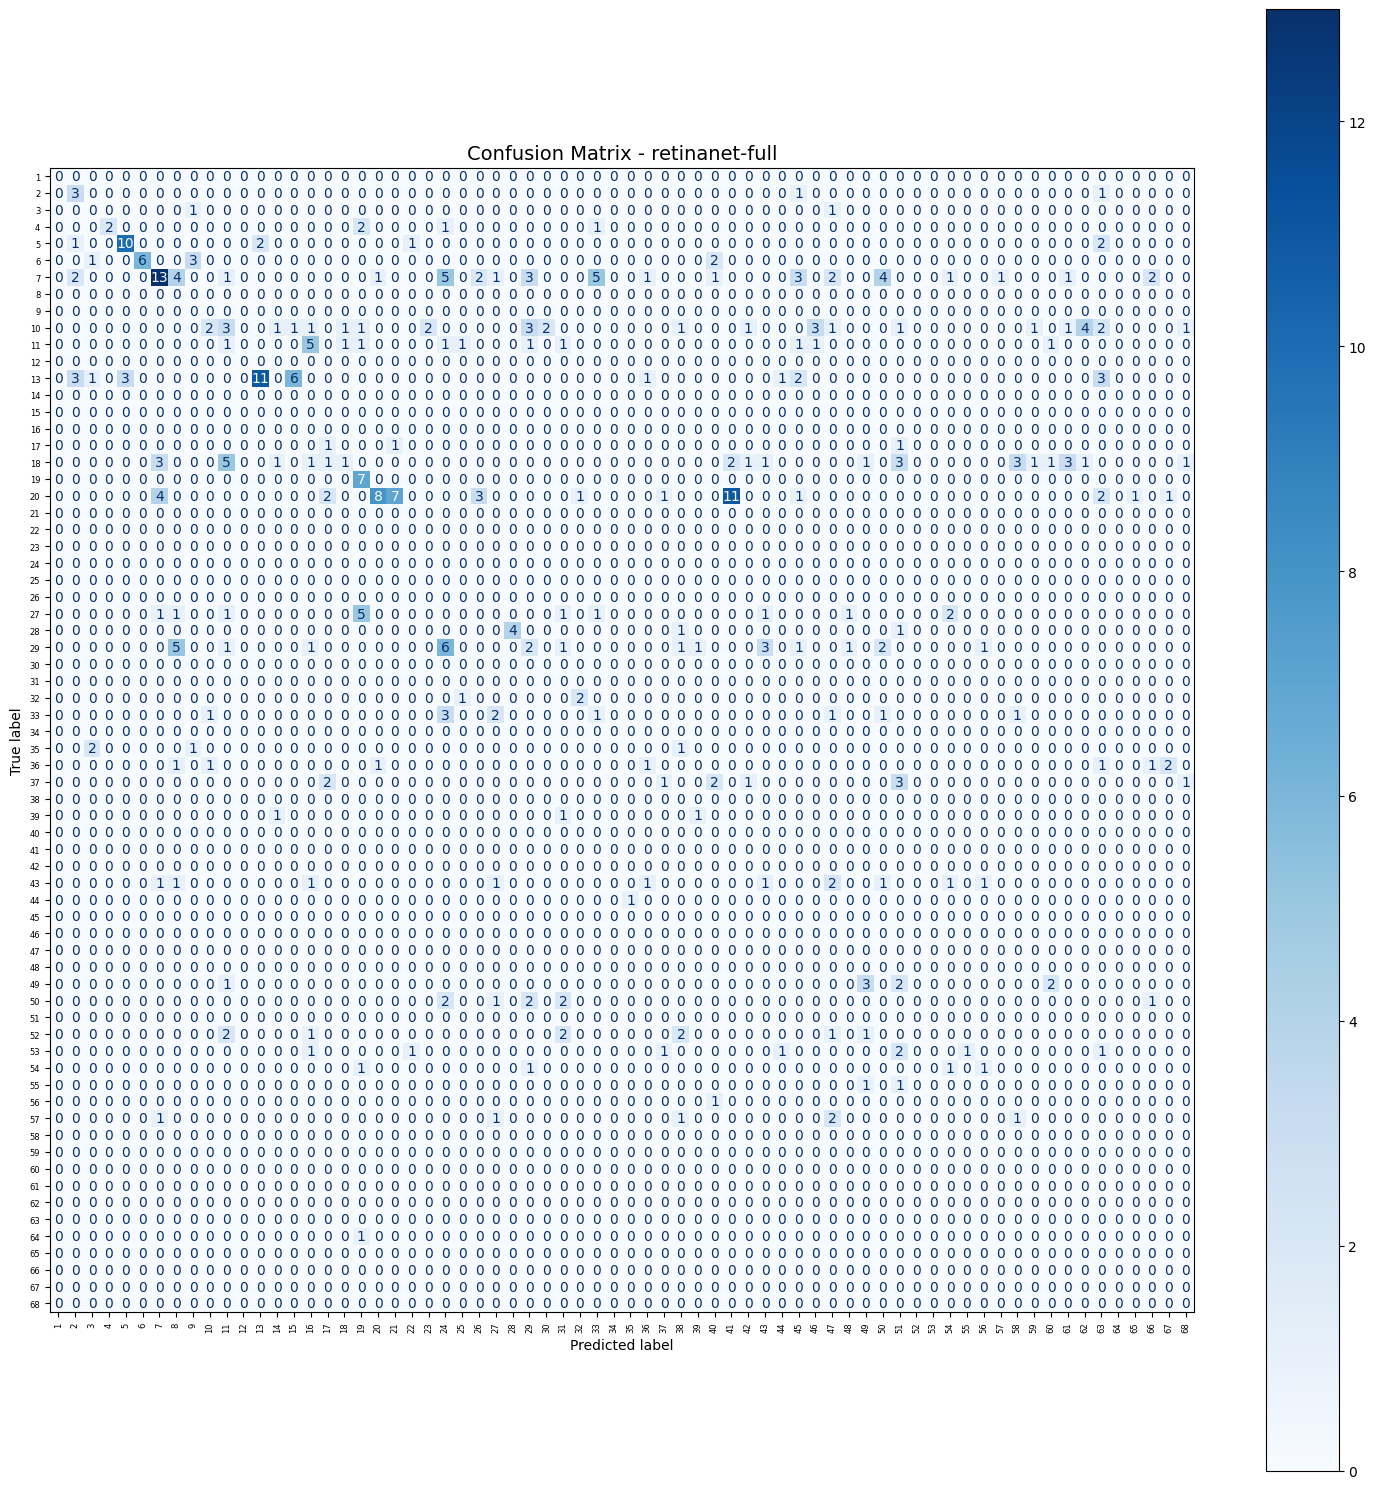

In [16]:
group = "retinanet-full"

checkpoint = torch.load(os.path.join(group, "epoch55.pt"), map_location=device)

model = get_retinanet_model(len(classes) + 1).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

predictions = []
targets = []

model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
  for images, targets in tqdm(val_dataloader, desc="Testing"):
    images, targets = to_device(images, targets)

    outputs = model(images)

    for output, target in zip(outputs, targets):
      y_true, y_pred = match_predictions_to_ground_truth(
          output["boxes"], output["labels"], target["boxes"], target["labels"]
      )
      y_true_all.extend(y_true)
      y_pred_all.extend(y_pred)

plot_confusion_matrix(y_true_all, y_pred_all, classes, title=f"Confusion Matrix - {group}")

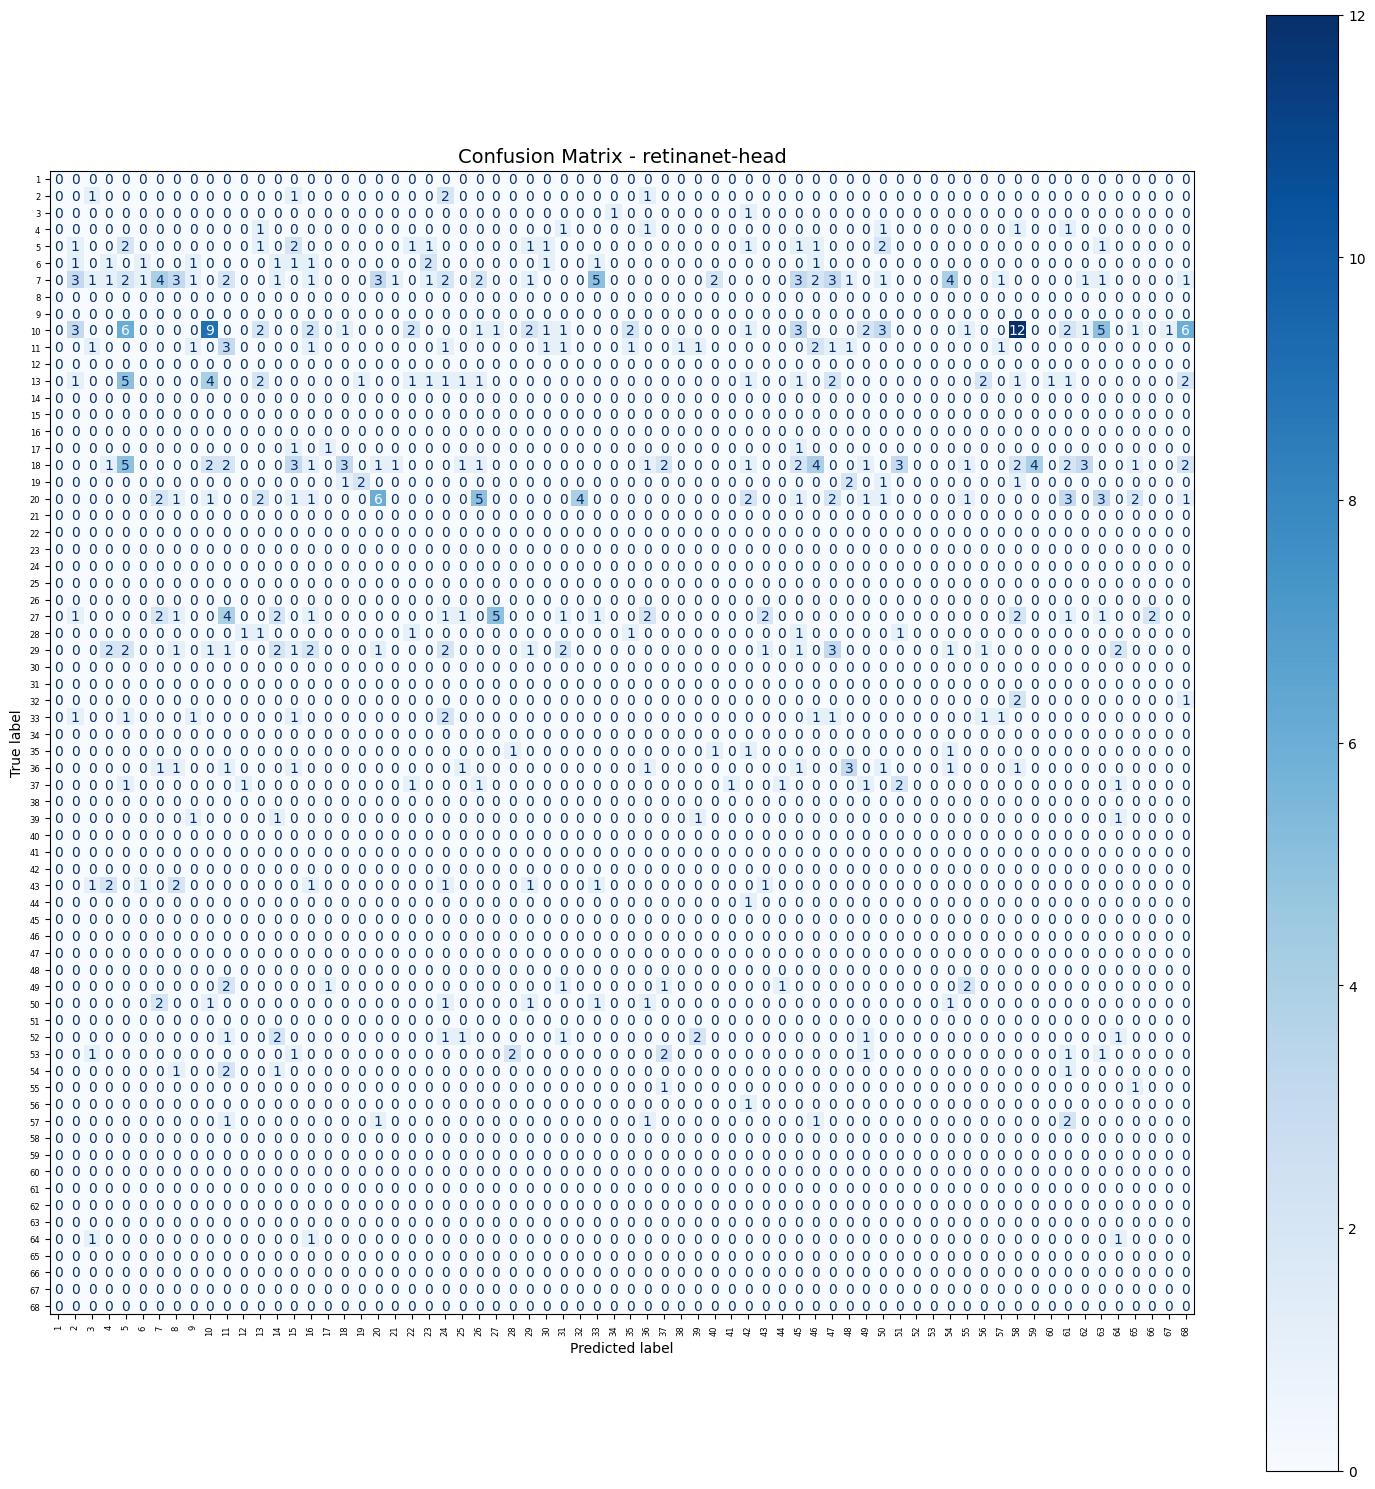

In [17]:
group = "retinanet-head"

checkpoint = torch.load(os.path.join(group, "epoch55.pt"), map_location=device)

model = get_retinanet_model(len(classes) + 1).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

predictions = []
targets = []

model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
  for images, targets in tqdm(val_dataloader, desc="Testing"):
    images, targets = to_device(images, targets)

    outputs = model(images)

    for output, target in zip(outputs, targets):
      y_true, y_pred = match_predictions_to_ground_truth(
          output["boxes"], output["labels"], target["boxes"], target["labels"]
      )
      y_true_all.extend(y_true)
      y_pred_all.extend(y_pred)

plot_confusion_matrix(y_true_all, y_pred_all, classes, title=f"Confusion Matrix - {group}")

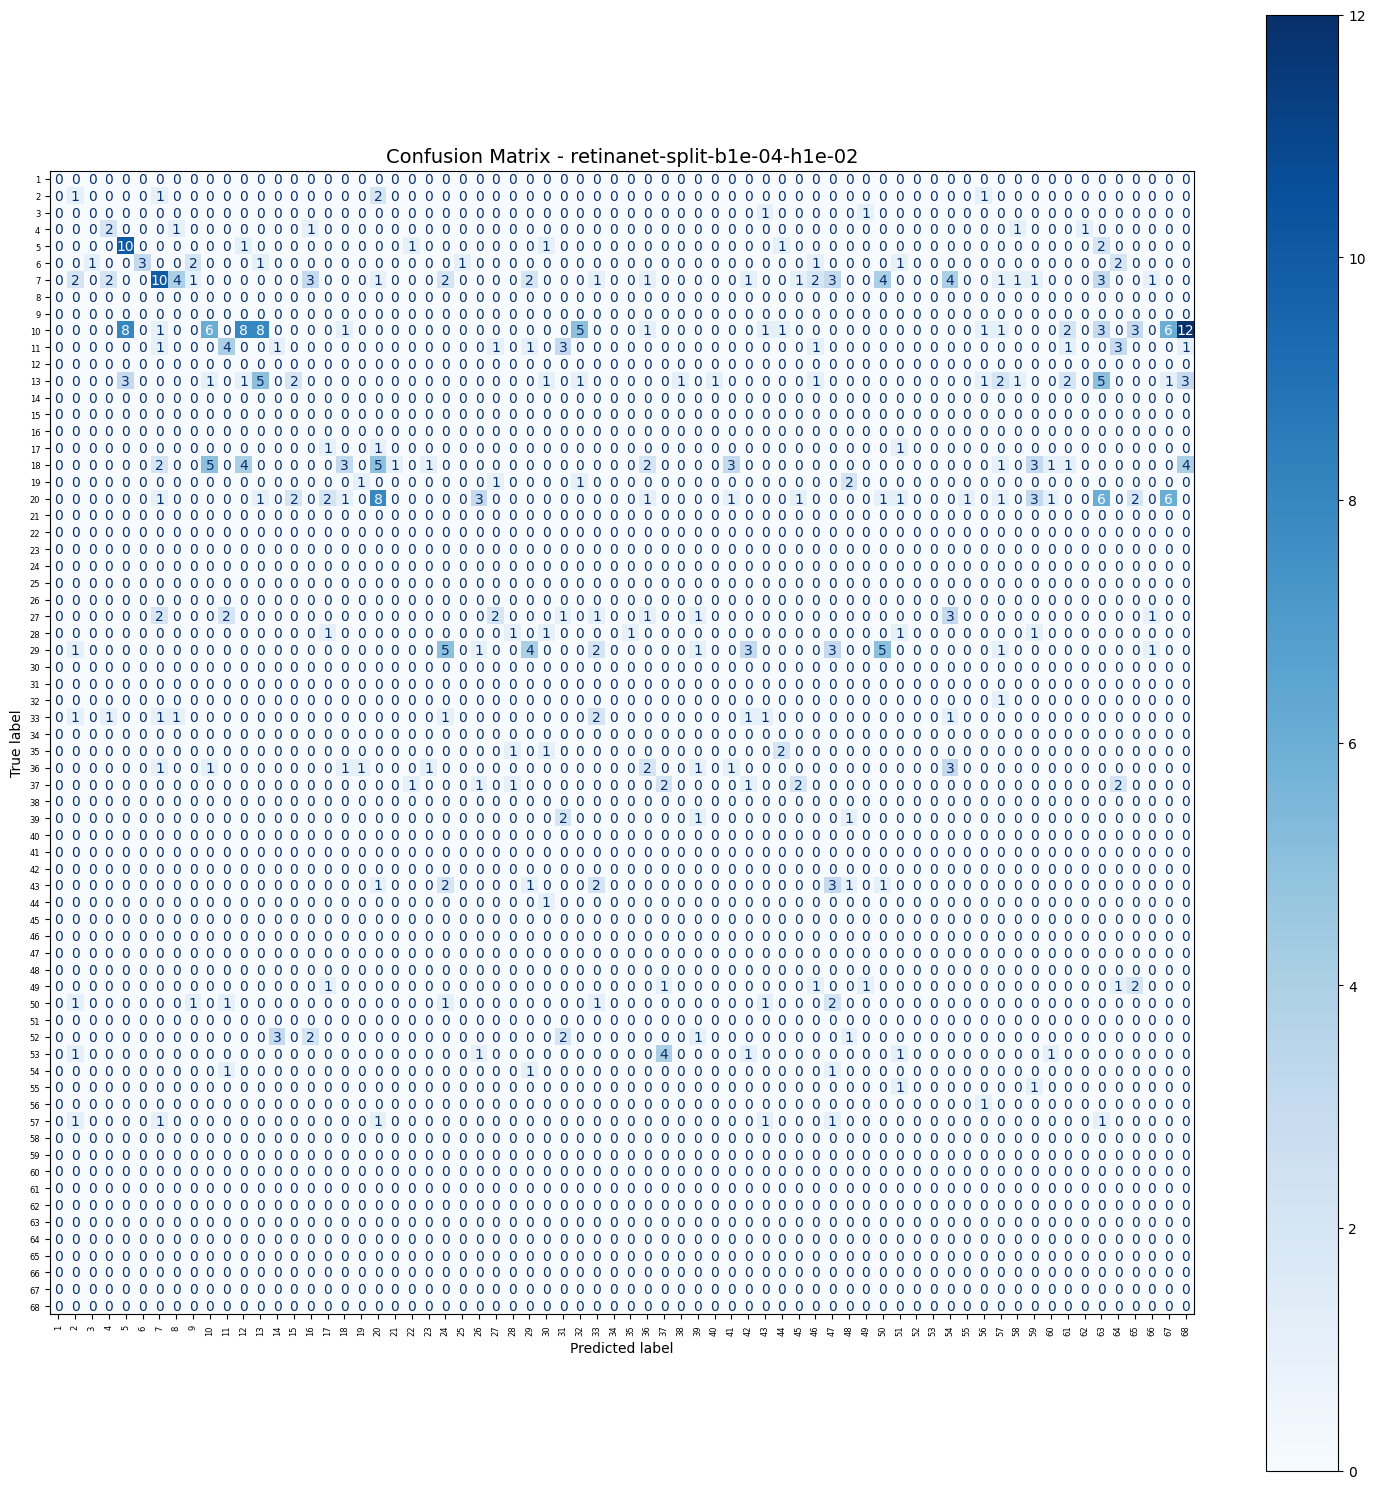

In [18]:
group = "retinanet-split-b1e-04-h1e-02"

checkpoint = torch.load(os.path.join(group, "epoch55.pt"), map_location=device)

model = get_retinanet_model(len(classes) + 1).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

predictions = []
targets = []

model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
  for images, targets in tqdm(val_dataloader, desc="Testing"):
    images, targets = to_device(images, targets)

    outputs = model(images)

    for output, target in zip(outputs, targets):
      y_true, y_pred = match_predictions_to_ground_truth(
          output["boxes"], output["labels"], target["boxes"], target["labels"]
      )
      y_true_all.extend(y_true)
      y_pred_all.extend(y_pred)

plot_confusion_matrix(y_true_all, y_pred_all, classes, title=f"Confusion Matrix - {group}")